# Сравнение решений задачи классификации узлов сети с использованием различных методов векторных представлений узлов

**Содержание:**


1.   Введение
2.   Основная часть\
    2.1.   Работа с данными\
    2.2.   Векторные представления узлов
          2.2.1     Матричное разложение
          2.2.2     Случайные блуждания
    2.3.   Классификация узлов
          2.3.1     Методы машинного обучения
          2.3.2     Нейронная сеть
3.   Заключение



## **1. Введение**

В данной работе рассматривается решение задачи классификации узлов с применением различных методов векторных представлений узлов. Классификация узлов графа является важным инструментом анализа и обработки графовых данных. Такая задача может встретиться в различных областях, например, в работе с социальными сетями или рекомендательными системами. Она состоит в присвоении меток узлам на графе на основе свойств узлов и взаимосвязей между ними.

Для успешного решения задачи классификации часто используются методы векторных представлений узлов, которые позволяют представить узлы в виде векторов, что может быть использовано при применении алгоритмов машинного обучения.

В исследовании будут применяться различные методы веторных представлений, а также несколько алгоритмов классификации узлов сети. По итогам экспериментального сравнения можно будет сделать выводы о том, какие методы и почему лучше решают поставленную задачу лучше или хуже.

В качестве данных для работы был выбран следующий набор:

Сеть из 100 тысяч пользователей, из которых около 5 тысяч были помечены как высказывающие ненависть пользователи или нет.
Также для каждого пользователя были предоставлены несколько актрибутов, связанных с их активностью в социальной сети. Ребра графа являются ретвитами пользователей, поэтому представленный граф является направленным.

Таким образом, классификация будет заключаться в нахождении пользователей, разжигающих ненависть - юинарная классификация


**Задачи:**


1.   Получить набор данных, готовый к применению
2.   Создать векторные представления узлов различными методами
3.   Провести классификацию узлов
4.   Сделать выводы о примененных методах



## install

In [1]:
!pip install node2vec

In [2]:
!pip install torch_geometric

In [3]:
!pip install karateclub

## **2. Основная часть**

In [4]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from node2vec import Node2Vec
from karateclub.node_embedding.neighbourhood import GraRep, HOPE, DeepWalk
import random
from scipy.sparse import coo_matrix
from karateclub.node_embedding.attributed import SINE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

## **2.1. Работа с данными**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
G0 = nx.read_edgelist('drive/MyDrive/users.edges', create_using = nx.DiGraph())
df0 = pd.read_csv('drive/MyDrive/users_neighborhood_anon.csv')
#df0.head()

Для классификации оставим только узлы, имеющие пометку.

In [7]:
df = df0[df0.hate != 'other'].reset_index(drop=True)
df

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,22,normal,False,True,111948,1586,997,80,7,960.147859,...,0.000548,0.000843,0.000200,0.001571,0.000467,0.005263,0.005594,0.000768,0.000973,0.011163
2,29,normal,False,True,28222,27545,282,916,499,60445.401832,...,0.001415,0.003107,0.000237,0.001487,0.001058,0.004290,0.008465,0.001763,0.003203,0.007599
3,44,normal,False,True,3101,2173,923,1193,11,21158.812380,...,0.000436,0.007613,0.000425,0.001987,0.000355,0.001157,0.010131,0.003298,0.001899,0.002811
4,85,normal,False,True,49169,2321,206,24755,37,4926.513875,...,0.000905,0.008520,0.000000,0.003538,0.000412,0.003487,0.004577,0.003098,0.003364,0.005171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,100332,normal,False,True,104905,3700,65,266,64,3387.440356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4967,100338,normal,False,True,5607,676,444,2664,24,16388.187011,...,0.000785,0.003694,0.000287,0.001985,0.001189,0.002902,0.007812,0.002805,0.002117,0.005742
4968,100362,normal,False,True,34,7534,527,1393,298,9278.713536,...,0.002501,0.014842,0.000787,0.001112,0.000443,0.004597,0.003462,0.003837,0.004023,0.011311
4969,100380,hateful,True,True,14608,49583,615,5373,927,153084.227764,...,0.000725,0.003434,0.000499,0.002734,0.000622,0.003903,0.005755,0.002673,0.002098,0.005707


normal     4427
hateful     544
Name: hate, dtype: int64


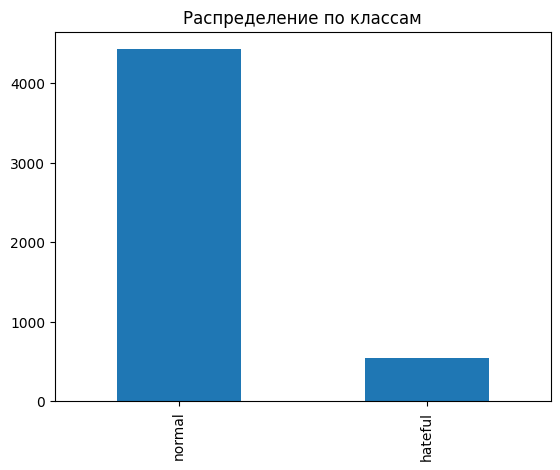

In [8]:
print(df.hate.value_counts())
df.hate.value_counts().plot(kind='bar')
plt.title('Распределение по классам')
plt.show()

Можно заметить, что классы являются несбалансированными, что может повлиять на дальнейшие результаты классификации, поэтому надо будет учесть это при выборе параметров моделей

In [9]:
df.hate = pd.get_dummies(df, columns=['hate'], drop_first = True)['hate_normal']
df

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,1,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,22,1,False,True,111948,1586,997,80,7,960.147859,...,0.000548,0.000843,0.000200,0.001571,0.000467,0.005263,0.005594,0.000768,0.000973,0.011163
2,29,1,False,True,28222,27545,282,916,499,60445.401832,...,0.001415,0.003107,0.000237,0.001487,0.001058,0.004290,0.008465,0.001763,0.003203,0.007599
3,44,1,False,True,3101,2173,923,1193,11,21158.812380,...,0.000436,0.007613,0.000425,0.001987,0.000355,0.001157,0.010131,0.003298,0.001899,0.002811
4,85,1,False,True,49169,2321,206,24755,37,4926.513875,...,0.000905,0.008520,0.000000,0.003538,0.000412,0.003487,0.004577,0.003098,0.003364,0.005171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,100332,1,False,True,104905,3700,65,266,64,3387.440356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4967,100338,1,False,True,5607,676,444,2664,24,16388.187011,...,0.000785,0.003694,0.000287,0.001985,0.001189,0.002902,0.007812,0.002805,0.002117,0.005742
4968,100362,1,False,True,34,7534,527,1393,298,9278.713536,...,0.002501,0.014842,0.000787,0.001112,0.000443,0.004597,0.003462,0.003837,0.004023,0.011311
4969,100380,0,True,True,14608,49583,615,5373,927,153084.227764,...,0.000725,0.003434,0.000499,0.002734,0.000622,0.003903,0.005755,0.002673,0.002098,0.005707


In [10]:
subgraph = G0.subgraph(map(str, df.user_id.to_list()))
print(subgraph)

DiGraph with 4971 nodes and 15141 edges


Удалим петли, так как они не несут в себе смысловой нагрузки в рамках выбранных данных

In [11]:
G = nx.relabel_nodes(subgraph, dict(zip(subgraph, map(int, subgraph.nodes()))))
G = nx.convert_node_labels_to_integers(G, ordering='sorted')
G.remove_edges_from(list(nx.selfloop_edges(G)))
print(G)
#nx.draw(G)

DiGraph with 4971 nodes and 10170 edges


Далее представлена десятая часть сети, где красным помечены пользователи, разжигающие ненависть

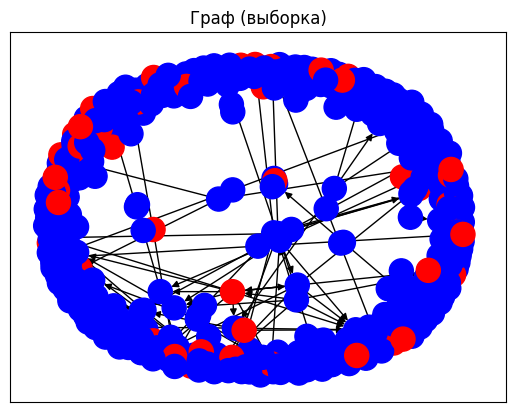

In [12]:
node_colors = list(map(lambda x: 'r' if x == 0 else 'b', df.hate))
nx.draw_networkx(G.subgraph(df.index.to_list()[::10]), node_color = node_colors[::10], with_labels = False)
plt.title('Граф (выборка)')
plt.show()

### **2.2. Векторные представления узлов**

Рассмотрим некоторые методы векторных представлений узлов, которые основаны на:

1) Матричном разложении

2) Случайных блужданиях

Для удобства при применении каждого из методов будем получать вектора одинаковой размерности

#### *2.2.1. Матричное разложение*

##### *Сингулярное разложение матрицы смежности узлов*

Самой простой способ получения векторных представлений узлов из графа с использованием матричной факторизации заключается в использовании метода Singular Value Decomposition (SVD), который уменьшает размерность матрицы смежности узлов посредством сингулярного разложения

In [13]:
A = nx.to_numpy_array(G)
svd = TruncatedSVD(n_components=32)
vec_svd = svd.fit_transform(A)
vec_svd.shape

(4971, 32)

##### *GraRep (Learning Graph Representations with Global Structural Information)*

Метод GraRep основывается на вычислении матрицы переходов, элементы который являются вероятностями перехода из одного узла в другой, рассчитанными на основе количества общих соседей этих узлов

In [14]:
model = GraRep(dimensions = 8, order = 4)
model.fit(G)

In [15]:
vec_grarep = model.get_embedding()
vec_grarep.shape

(4971, 32)

##### *HOPE (Higher-Order Proximity Embeddings)*

Метод HOPE основан на идее, что узлы, которые имеют сходную структуру связей с другими узлами, должны иметь схожие векторные представления. Особенность алгоритма в том, что он учитывает связи выше второго порядка

In [16]:
model = HOPE(dimensions = 32)
model.fit(G)

In [17]:
vec_hope = model.get_embedding()
vec_hope.shape

(4971, 32)

#### *2.2.2. Случайные блуждания*

Методы, который вычисляют векторные представления узла на основе случайных блужданий в графе: DeepWalk и Node2Vec.

Node2Vec - это вариация DeepWalk, которая вводит смещенные
случайные блуждания. Случайными блужданиями управляют два параметра: p уменьшает
вероятность повторного посещения предыдущего узла, в то время
как q уменьшает вероятность перехода к узлам, которые
не были соседями исходного узла.

###### *DeepWalk*

In [18]:
model = DeepWalk(dimensions = 32, walk_length=30, workers=4, walk_number = 50)
model.fit(G)

In [19]:
vec_deepwalk = model.get_embedding()
vec_deepwalk.shape

(4971, 32)

##### *Node2Vec*

In [20]:
node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=30, workers=4, p = 1.3, q = 0.7)
model = node2vec.fit(window=10, min_count=1)
vec_node2vec = np.array([model.wv[node] for node in G.nodes()])
vec_node2vec.shape

Computing transition probabilities:   0%|          | 0/4971 [00:00<?, ?it/s]

(4971, 32)

##### *SINE (Scalable Incomplete Network Embedding)*

Метод SINE позволяет использовать атрибуты узлов для построения векторов.

Процедура неявно факторизует совместную мощность матрицы смежности и матрицы признаков. Декомпозиция выполняется на основе усеченных случайных блужданий, и мощности матрицы смежности объединяются.

In [21]:
df_features = df.iloc[:, 2:].select_dtypes(include='number')
features = df_features.to_numpy()

In [22]:
X = coo_matrix(features)
model = SINE(dimensions = 32)
model.fit(G, X)

In [23]:
vec_sine = model.get_embedding()
vec_sine.shape

(4971, 32)

### **2.3. Классификация узлов**

Чтобы получить более точные результаты сравнения, классификацию будем проводить разными методами:

1) Методы машинного обучения

2) Нейронная сеть

#### *2.3.1. Методы машинного обучения*

Разделим данные на обучающую и тестовую выборки, а также найдем веса классов

In [24]:
train_mask, test_mask = train_test_split(df.index, test_size=0.2)
y = df.hate
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
cw = dict(zip(np.unique(y), class_weights))

##### *SVC (Support Vector Classifier)*

Работает путем нахождения гиперплоскости в многомерном пространстве, которая разделяет точки данных на разные классы.

In [25]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_svd[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [26]:
svd_res = clf.predict(vec_svd[test_mask])
svc_res = [f1_score(y[test_mask], svd_res, average = 'macro')]
print(classification_report(svd_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.92      0.12      0.21       886
           1       0.11      0.92      0.20       109

    accuracy                           0.20       995
   macro avg       0.52      0.52      0.20       995
weighted avg       0.83      0.20      0.21       995



In [27]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_grarep[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [28]:
grarep_res = clf.predict(vec_grarep[test_mask])
svc_res.append(f1_score(y[test_mask], grarep_res, average = 'macro'))
print(classification_report(grarep_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.70      0.53      0.60       147
           1       0.92      0.96      0.94       848

    accuracy                           0.90       995
   macro avg       0.81      0.75      0.77       995
weighted avg       0.89      0.90      0.89       995



In [29]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_hope[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [30]:
hope_res = clf.predict(vec_hope[test_mask])
svc_res.append(f1_score(y[test_mask], hope_res, average = 'macro'))
print(classification_report(hope_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       120
           1       0.95      0.95      0.95       875

    accuracy                           0.91       995
   macro avg       0.79      0.78      0.79       995
weighted avg       0.91      0.91      0.91       995



In [31]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_deepwalk[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [32]:
deepwalk_res = clf.predict(vec_deepwalk[test_mask])
svc_res.append(f1_score(y[test_mask], deepwalk_res, average = 'macro'))
print(classification_report(deepwalk_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55       118
           1       0.94      0.94      0.94       877

    accuracy                           0.90       995
   macro avg       0.75      0.74      0.74       995
weighted avg       0.89      0.90      0.89       995



In [33]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_node2vec[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [34]:
node2vec_res = clf.predict(vec_node2vec[test_mask])
svc_res.append(f1_score(y[test_mask], node2vec_res, average = 'macro'))
print(classification_report(node2vec_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.43      0.12      0.19       396
           1       0.61      0.89      0.72       599

    accuracy                           0.59       995
   macro avg       0.52      0.51      0.46       995
weighted avg       0.54      0.59      0.51       995



In [35]:
clf = svm.SVC(class_weight = cw)
clf.fit(vec_sine[train_mask], y[train_mask])

SVC(class_weight={0: 4.568933823529412, 1: 0.5614411565394172})

In [36]:
sine_res = clf.predict(vec_sine[test_mask])
svc_res.append(f1_score(y[test_mask], sine_res, average = 'macro'))
print(classification_report(sine_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61       135
           1       0.93      0.96      0.94       860

    accuracy                           0.90       995
   macro avg       0.80      0.76      0.78       995
weighted avg       0.90      0.90      0.90       995



In [37]:
pd.DataFrame(svc_res, columns=['f1_score'], index = ['svd','grarep','hope','deepwalk', 'node2vec', 'sine']).sort_values(by='f1_score', ascending = False)

,f1_score
hope,0.785316
sine,0.775818
grarep,0.771407
deepwalk,0.744368
node2vec,0.455487
svd,0.204013


Лучший результат по f1-score показал метод SINE, который при обучении векторов использует атрибуты узлов. Атрибуты узлов в свою очередь являются своеобразными характеристика поведения пользователей, поэтому метод может быть очень показателен при наличии таких данных.

Второе место у HOPE. Можно предположить, что это происходит из-за того, что HOPE, в отличие от остальных методов, рассматривает связи выше второго порядка, то есть углубляется в сеть и взаимосвязи между пользователями. В рамках взятых данных - социальная сеть с ретвитами - это может означать, что пользователи, разжигающие ненависть, имеют определенные не сразу заметные сходства.

На последних местах svd и Node2Vec. Первое не вызывает особых вопросов, в связи с поверхностностью построения векторов. Node2Vec, вероятно, показывает плохой результат из-за неправильно подобрабных параметров при обучении векторов.

##### *Random Forest*

Работает путем построения множества деревьев решений и объединения их предсказаний.


In [38]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_svd[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [39]:
svd_res = clf.predict(vec_svd[test_mask])
rf_res = [f1_score(y[test_mask], svd_res, average = 'macro')]
print(classification_report(svd_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.68      0.11      0.19       699
           1       0.29      0.88      0.44       296

    accuracy                           0.34       995
   macro avg       0.49      0.49      0.31       995
weighted avg       0.56      0.34      0.26       995



In [40]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_grarep[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [41]:
grarep_res = clf.predict(vec_grarep[test_mask])
rf_res.append(f1_score(y[test_mask], grarep_res, average = 'macro'))
print(classification_report(grarep_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.46      0.64      0.54        81
           1       0.97      0.93      0.95       914

    accuracy                           0.91       995
   macro avg       0.72      0.79      0.74       995
weighted avg       0.93      0.91      0.92       995



In [42]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_hope[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [43]:
hope_res = clf.predict(vec_hope[test_mask])
rf_res.append(f1_score(y[test_mask], hope_res, average = 'macro'))
print(classification_report(hope_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.39      0.76      0.52        58
           1       0.98      0.93      0.95       937

    accuracy                           0.92       995
   macro avg       0.69      0.84      0.74       995
weighted avg       0.95      0.92      0.93       995



In [44]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_deepwalk[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [45]:
deepwalk_res = clf.predict(vec_deepwalk[test_mask])
rf_res.append(f1_score(y[test_mask], deepwalk_res, average = 'macro'))
print(classification_report(deepwalk_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.09      0.91      0.16        11
           1       1.00      0.90      0.94       984

    accuracy                           0.90       995
   macro avg       0.54      0.90      0.55       995
weighted avg       0.99      0.90      0.94       995



In [46]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_node2vec[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [47]:
node2vec_res = clf.predict(vec_node2vec[test_mask])
rf_res.append(f1_score(y[test_mask], node2vec_res, average = 'macro'))
print(classification_report(node2vec_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.99      0.89      0.94       990

    accuracy                           0.88       995
   macro avg       0.50      0.44      0.47       995
weighted avg       0.99      0.88      0.93       995



In [48]:
clf = RandomForestClassifier(class_weight = cw)
clf.fit(vec_sine[train_mask], y[train_mask])

RandomForestClassifier(class_weight={0: 4.568933823529412,
                                     1: 0.5614411565394172})

In [49]:
sine_res = clf.predict(vec_sine[test_mask])
rf_res.append(f1_score(y[test_mask], sine_res, average = 'macro'))
print(classification_report(sine_res, y[test_mask]))

              precision    recall  f1-score   support

           0       0.39      0.86      0.54        51
           1       0.99      0.93      0.96       944

    accuracy                           0.92       995
   macro avg       0.69      0.90      0.75       995
weighted avg       0.96      0.92      0.94       995



In [50]:
pd.DataFrame(rf_res, columns=['f1_score'], index = ['svd','grarep','hope','deepwalk', 'node2vec', 'sine']).sort_values(by='f1_score', ascending = False)

,f1_score
sine,0.749413
grarep,0.744667
hope,0.736296
deepwalk,0.553716
node2vec,0.468767
svd,0.314237


В случае модели Случайного леса лучшим стал снова метод SINE.

Можно еще выделить метод GraRep, который занял 2 место по f1-score, несмотря на относительно небольшую вычислительную мощность. Данный метод учитывает первостепенные и второстепенные связи, на основе которых, как показала практика, можно получить хорошие результаты классификации.

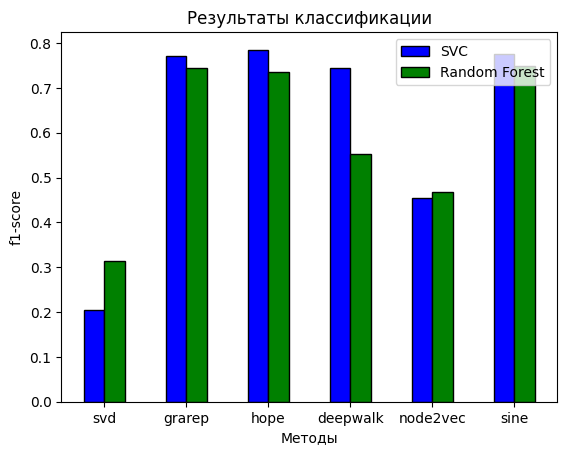

In [51]:
r = np.arange(6)
width = 0.25

plt.bar(r, svc_res, color = 'b', width = width, edgecolor = 'black', label='SVC')
plt.bar(r + width, rf_res, color = 'g', width = width, edgecolor = 'black', label='Random Forest')

plt.xlabel("Методы")
plt.ylabel("f1-score")
plt.title("Результаты классификации")

plt.xticks(r + width/2,['svd','grarep','hope','deepwalk', 'node2vec', 'sine'])
plt.legend()
plt.show()

Обобщая результаты проведенной классификации двумя алгоритмами машинного обучения, можено сделать вывод, что для социальной сети лучше подходит SVC модель, которая находит оптимальную гиперплоскость для разделения классов. Так как данные имеют векторное представление, такой результат можно назвать закономерным

Интересно, что DeepWalk, который использует только случайные блуждания для построения векторных представлений, имеет большое различие между f1-score

#### *2.3.2. Нейронная сеть*

Далее попробуем классифицировать узлы при помощи графовой сверточной сети.

Сначала в качестве признаков узлов будем использовать атрибуты узлов, уменьшенные в размерности с помощью сингулярного разложения, а после - векторные представления узлов, полученные ранее

In [72]:
class GCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.conv1 = GCNConv(n_input, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_output)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [73]:
n_epochs = 301
n_input = 32
n_hidden = 128
n_out = 2

In [74]:
def visualize():
  model.eval()
  with torch.no_grad():
      predictions = model(data)

  for cl in labels.unique():
      plt.scatter(predictions[cl == labels, 0], predictions[cl == labels, 1], label=str(cl.item()), linewidths = 5)
  plt.legend()
  plt.show()

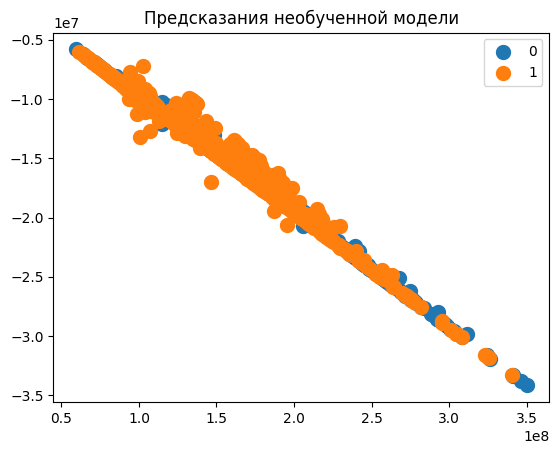

In [75]:
model = GCN(n_input, n_hidden, n_out)

svd = TruncatedSVD(n_components=32)
features32 = svd.fit_transform(df_features.fillna(df.mean(numeric_only=True)).to_numpy())

labels = torch.tensor(y).to(torch.int64)
edges = torch.tensor(list(G.edges)).t().contiguous().long()
data = Data(x = torch.from_numpy(features32).to(torch.float32), edge_index = edges)

plt.title('Предсказания необученной модели')
visualize()

In [76]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 20:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res = [f1_score(predictions[test_mask], labels[test_mask], average = 'macro')]

In epoch 0, train acc: 0.109, test acc: 0.113
In epoch 20, train acc: 0.891, test acc: 0.887
In epoch 40, train acc: 0.109, test acc: 0.114
In epoch 60, train acc: 0.891, test acc: 0.887
In epoch 80, train acc: 0.109, test acc: 0.114
In epoch 100, train acc: 0.891, test acc: 0.887
In epoch 120, train acc: 0.891, test acc: 0.886
In epoch 140, train acc: 0.891, test acc: 0.887
In epoch 160, train acc: 0.891, test acc: 0.887
In epoch 180, train acc: 0.891, test acc: 0.887
In epoch 200, train acc: 0.191, test acc: 0.188
In epoch 220, train acc: 0.891, test acc: 0.887
In epoch 240, train acc: 0.891, test acc: 0.887
In epoch 260, train acc: 0.891, test acc: 0.887
In epoch 280, train acc: 0.891, test acc: 0.887
In epoch 300, train acc: 0.891, test acc: 0.887


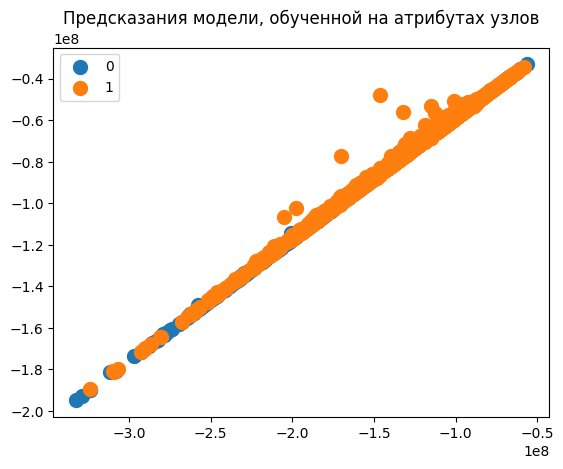

In [77]:
plt.title('Предсказания модели, обученной на атрибутах узлов')
visualize()

In [78]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_svd).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.362, test acc: 0.366
In epoch 40, train acc: 0.892, test acc: 0.885
In epoch 80, train acc: 0.897, test acc: 0.884
In epoch 120, train acc: 0.907, test acc: 0.891
In epoch 160, train acc: 0.920, test acc: 0.903
In epoch 200, train acc: 0.926, test acc: 0.904
In epoch 240, train acc: 0.927, test acc: 0.908
In epoch 280, train acc: 0.930, test acc: 0.907


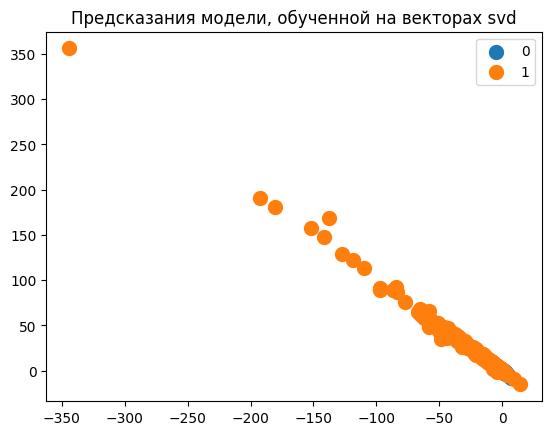

In [79]:
plt.title('Предсказания модели, обученной на векторах svd')
visualize()

In [80]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_grarep).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.693, test acc: 0.694
In epoch 40, train acc: 0.908, test acc: 0.910
In epoch 80, train acc: 0.912, test acc: 0.905
In epoch 120, train acc: 0.889, test acc: 0.898
In epoch 160, train acc: 0.894, test acc: 0.889
In epoch 200, train acc: 0.910, test acc: 0.908
In epoch 240, train acc: 0.917, test acc: 0.912
In epoch 280, train acc: 0.924, test acc: 0.919


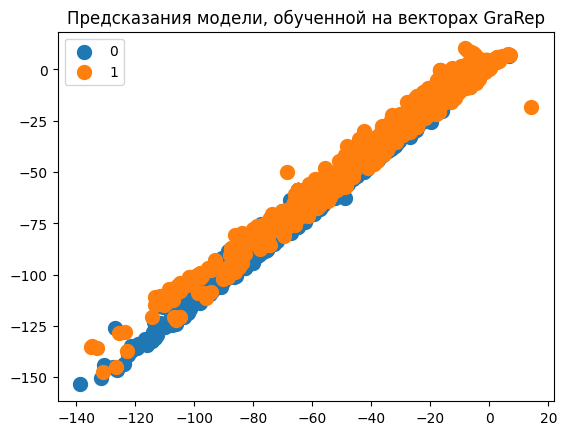

In [81]:
plt.title('Предсказания модели, обученной на векторах GraRep')
visualize()

In [82]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_hope).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.462, test acc: 0.454
In epoch 40, train acc: 0.926, test acc: 0.918
In epoch 80, train acc: 0.931, test acc: 0.920
In epoch 120, train acc: 0.937, test acc: 0.923
In epoch 160, train acc: 0.941, test acc: 0.918
In epoch 200, train acc: 0.944, test acc: 0.922
In epoch 240, train acc: 0.947, test acc: 0.918
In epoch 280, train acc: 0.950, test acc: 0.919


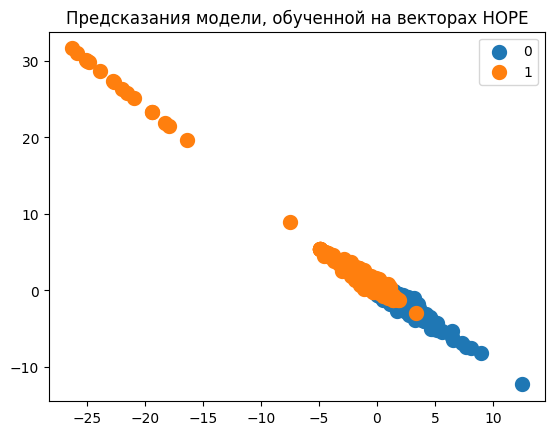

In [83]:
plt.title('Предсказания модели, обученной на векторах HOPE')
visualize()

In [84]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_deepwalk).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.362, test acc: 0.349
In epoch 40, train acc: 0.925, test acc: 0.920
In epoch 80, train acc: 0.928, test acc: 0.916
In epoch 120, train acc: 0.932, test acc: 0.918
In epoch 160, train acc: 0.944, test acc: 0.916
In epoch 200, train acc: 0.953, test acc: 0.913
In epoch 240, train acc: 0.960, test acc: 0.905
In epoch 280, train acc: 0.968, test acc: 0.898


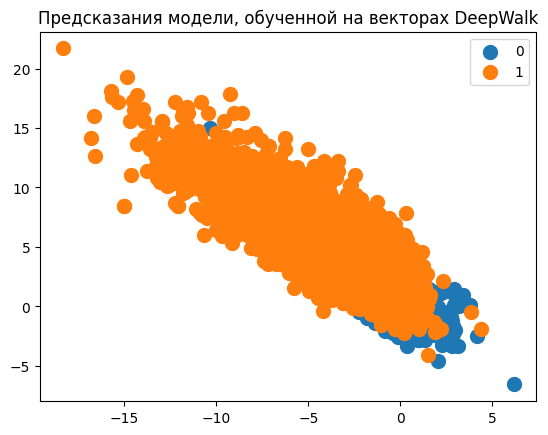

In [85]:
plt.title('Предсказания модели, обученной на векторах DeepWalk')
visualize()

In [86]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_node2vec).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.198, test acc: 0.191
In epoch 40, train acc: 0.892, test acc: 0.887
In epoch 80, train acc: 0.901, test acc: 0.896
In epoch 120, train acc: 0.916, test acc: 0.899
In epoch 160, train acc: 0.924, test acc: 0.899
In epoch 200, train acc: 0.929, test acc: 0.904
In epoch 240, train acc: 0.935, test acc: 0.906
In epoch 280, train acc: 0.939, test acc: 0.899


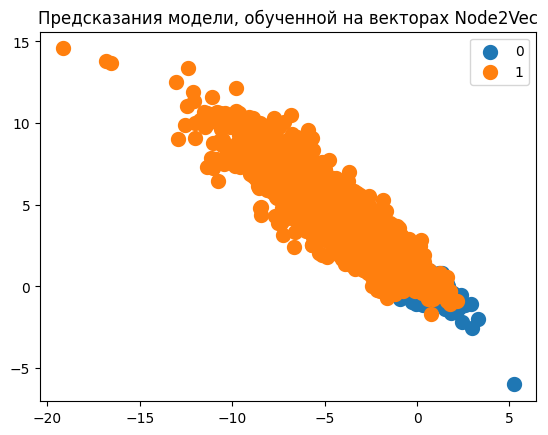

In [87]:
plt.title('Предсказания модели, обученной на векторах Node2Vec')
visualize()

In [88]:
model = GCN(n_input, n_hidden, n_out)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

data = Data(x = torch.from_numpy(vec_sine).to(torch.float32), edge_index = edges)

for epoch in range(n_epochs):
    logits = model(data)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        train_acc = (predictions[train_mask] == labels[train_mask]).float().mean()
        test_acc = (predictions[test_mask] == labels[test_mask]).float().mean()

    if not epoch % 40:
        print(f'In epoch {epoch}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}')

gcn_res.append(f1_score(predictions[test_mask], labels[test_mask], average = 'macro'))

In epoch 0, train acc: 0.397, test acc: 0.422
In epoch 40, train acc: 0.922, test acc: 0.923
In epoch 80, train acc: 0.926, test acc: 0.921
In epoch 120, train acc: 0.929, test acc: 0.921
In epoch 160, train acc: 0.933, test acc: 0.920
In epoch 200, train acc: 0.932, test acc: 0.920
In epoch 240, train acc: 0.935, test acc: 0.921
In epoch 280, train acc: 0.940, test acc: 0.917


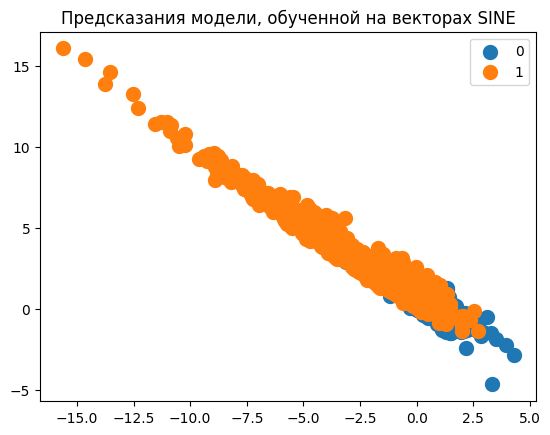

In [89]:
plt.title('Предсказания модели, обученной на векторах SINE')
visualize()

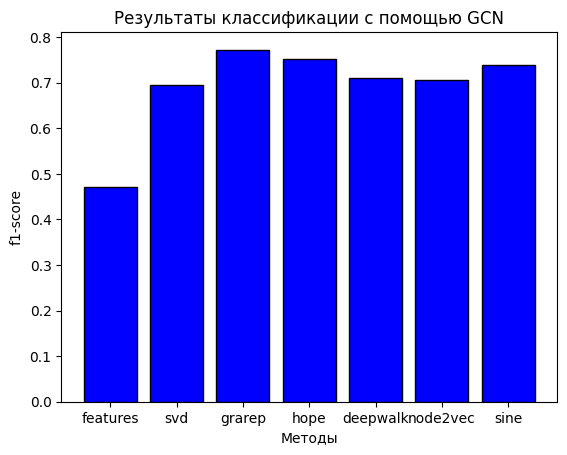

In [90]:
r = np.arange(7)

plt.bar(r, gcn_res, color = 'b', edgecolor = 'black')

plt.xlabel("Методы")
plt.ylabel("f1-score")
plt.title("Результаты классификации с помощью GCN")

plt.xticks(r,['features', 'svd','grarep','hope','deepwalk', 'node2vec', 'sine'])
plt.show()

In [91]:
pd.DataFrame(gcn_res, columns=['f1_score'], index = ['features','svd','grarep','hope','deepwalk', 'node2vec', 'sine']).sort_values(by='f1_score', ascending = False)

,f1_score
grarep,0.772266
hope,0.752048
sine,0.738222
deepwalk,0.710950
node2vec,0.706296
svd,0.694442
features,0.470181


При одинаковых параметров обучения, лучше всего себя показали те же методы, что и раньше. При этом обучение только на атрибутах узлов дало довольно плохой результат, в отличие от векторных представлений, полученных в ходе работы.

## **3. Заключение**

По итогам работы мы получили результаты классификации узлов сети несколькими способами. Можно сказать, что методы, глубоко рассматривающие взаимосвязи между узлами, лучше справляются с задачей классификации. Конечно, данные выводы распространяются только на выбранный набор данных и, вероятнее всего, могут быть распространены только на данные со схожей структурой.

В рамках задачи классификации пользователей, разжигающих ненависть, хорошо себя показал метод SINE, учитывающий и отношения между объектами сети, и атрибуты узлов. А также методы HOPE и GraRep, первый их которых включает в рассмотрение связи выше второго порядка, а второй - первого и второго.

Говоря о алгоритмах классификации, поскольку для обучения не подбирались специальные параметры, сложно сделать вывод о том, какой является наилучшим в широком смысле. Однако в ходе проведенного эксперимента при прочих равных условиях наибольшие значения получились при использовании SVC.

## **Список используемых источников:**

1.   Данные - https://www.kaggle.com/datasets/manoelribeiro/hateful-users-on-twitter
2.   Karate Club: An API Oriented Open-source Python Framework for Unsupervised Learning on Graphs (CIKM 2020) - https://github.com/benedekrozemberczki/karateclub
3.   Под капотом графовых сетей - https://habr.com/ru/articles/794558/
4.   Characterizing and Detecting Hateful Users on Twitter - https://www.researchgate.net/publication/365061339_Characterizing_and_Detecting_Hateful_Users_on_Twitter

